In [1]:
import pandas as pd
import numpy as np
import os
import sqlite3
import datetime

# //*** Imports and Load Data
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


output_width = 1000
#output_width = 80 #//*** Normal Output width
pd.set_option("display.width", output_width)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

#pd.set_option('display.width', None)


Begin Milestone 1 with a 250-500-word narrative describing an original idea for an analysis/model building business problem. Then, do a graphical analysis creating a minimum of four graphs. Label your graphs appropriately and explain/analyze the information provided by each graph. Keep in mind that your analysis may look very different from the Titanic tutorial graphical analysis. Write a short overview/conclusion of the insights gained from your graphical analysis.

In [2]:
# //*** Legends automatically generate too many labels based on my looping method.
# //*** Remove the Duplicate Legends. I wrote this for DSC 530 and it keeps on giving.
def deduplicate_legend(input_ax):
    # //**** Get handle and label list for the current legend
    # //**** Use first instance, toss the rest.
    handles, labels = input_ax.get_legend_handles_labels()

    handle_dict = {}

    for x in range(len(labels)):
        if labels[x] not in handle_dict.keys():
            # //*** Label = handle
            handle_dict[labels[x]] = handles[x]

    # //*** Build unique output ists and handles
    out_handles = []
    out_labels = []
    
    for label,handle in handle_dict.items():
        out_handles.append(handle)
        out_labels.append(label)
    
    return out_handles,out_labels

   

In [3]:
########################################
#//*** Load all data from a database 
########################################
db_filename = 'frozen_covid_data.sqldb'

#//*** Verify database instance exists
if os.path.exists(db_filename) == False:
    #//*** Throw a warning if databse does not exist
    print(f"Trouble Connecting to database: {db_filename}")
else:
    #//*** Start a database connection
    con = sqlite3.connect(db_filename)
    
    #//*** Use a manual list of names to convert from SQL. This is much less elegant coming out
    #//*** Than it did going in. But it is expedient
    
    for df_name in ['covid_ethnic_df','covid_cases_df','pop_attrib_df','covid_project_df']:

        #//******************************************    
        #//*** Build loop_df based on string name
        #//******************************************
        if df_name == 'covid_ethnic_df':
            covid_ethnic_df = pd.read_sql(f"SELECT * FROM {df_name}",con=con)
        elif df_name == 'covid_cases_df':
            covid_cases_df = pd.read_sql(f"SELECT * FROM {df_name}",con=con).set_index('index')
        elif df_name == 'pop_attrib_df':
            pop_attrib_df = pd.read_sql(f"SELECT * FROM {df_name}",con=con).set_index('index')
        elif df_name == 'covid_project_df':
            covid_project_df = pd.read_sql(f"SELECT * FROM {df_name}",con=con).set_index('index')
            covid_project_df['date'] = pd.to_datetime(covid_project_df['date'])
        else:
            #//*** Display and error message for items missed. 
            print(f"Failed to process: {df_name}")
            continue

    #//*** Close and Exit the Database. For 
    con.close()
    con.__exit__


In [4]:
#//*** Set the index column as the index
for df in [covid_ethnic_df, covid_cases_df, pop_attrib_df,covid_project_df]:
    if 'index' in df.columns:
        df = df.set_index('index')

In [5]:
#//*************************************
#//*** Import stored/preprocessed data
#//*************************************

#//*** Columns to remove from imported CSVs. We should be able to kill these on import if we were cool.
#//*** But we're not, so we'll use an expedient column delete list.

del_cols = ['Unnamed: 0', '_id']


#//***********************************************************************************
#//*** Remove excess columns from read_csv
#//*** Use the loop in case we need to delete columns that are not exclusive to all
#//***********************************************************************************
for x in del_cols:
    if x in covid_cases_df.columns:
        covid_cases_df.drop([x], axis=1, inplace=True)

    if x in covid_ethnic_df.columns:
        covid_ethnic_df.drop([x], axis=1, inplace=True)
    
    if x in pop_attrib_df.columns:
        pop_attrib_df.drop([x], axis=1, inplace=True)
    
    if x in covid_project_df.columns:
        covid_project_df.drop([x], axis=1, inplace=True)
        
#print(covid_cases_df.head())

#//*** Drop the counties labeled as unassigned.
#//*** We don't have data on those individuals
#print(f"Length Before removing Unassigned County: {len(covid_cases_df)}")

#covid_cases_df = covid_cases_df[~covid_cases_df['county'].isin(['Unassigned'])]

#print(f"Length After removing Unassigned County: {len(covid_cases_df)}")

#//*** Remove the 'Out Of Country' listings
#print(f"Length Before removing Out Of Country County: {len(covid_cases_df)}")

covid_cases_df = covid_cases_df[~covid_cases_df['county'].isin(['Out Of Country'])]

#print(f"Length After removing Out Of Country County: {len(covid_cases_df)}")


#//*** Drop the rows with Other listed as ethnicity. This reopresents less than .1 % pf the population and doesn't have an
#//*** Equivalent in the federal data.
#print(f"Length Before removing Other Race: {len(covid_ethnic_df)}")

covid_ethnic_df = covid_ethnic_df[~covid_ethnic_df['race_ethnicity'].isin(['Other'])]

#print(f"Length After removing Other Race: {len(covid_ethnic_df)}")



In [6]:
#//*** Combine Pacific Islander and Hawaiian values into one.
#//*** Hawaiian isn't a good choice of variable name. It's kind of racist and definitely non-inclusive.
#//*** But I need this to work, before I can reconsider a different variable name

covid_ethnic_df['race_ethnicity']=covid_ethnic_df['race_ethnicity'].str.replace('Native Hawaiian or Pacific Islander','Hawaiian')
covid_ethnic_df['race_ethnicity']=covid_ethnic_df['race_ethnicity'].str.replace('Native Hawaiian and other Pacific Islander','Hawaiian')
covid_ethnic_df['race_ethnicity']=covid_ethnic_df['race_ethnicity'].str.replace('Multi-Race','Multiracial' )
covid_ethnic_df['race_ethnicity']=covid_ethnic_df['race_ethnicity'].str.replace('American Indian or Alaska Native','Native' )

In [7]:
#//*** Generate State Total populations by Race
pop_state = {
    'total' : pop_attrib_df['population'].sum(),
    'Latino' : pop_attrib_df['Latino'].sum(),
    'White' : pop_attrib_df['White'].sum(),
    'Asian' : pop_attrib_df['Asian'].sum(),
    'Black' : pop_attrib_df['Black'].sum(),
    'Native' : pop_attrib_df['American Indian or Alaska Native'].sum(),
    'Hawaiian' : pop_attrib_df['Hawaiian'].sum(),
    'Multiracial' : pop_attrib_df['Multiracial'].sum()
}
print(f"Total Population: {pop_state['total']}")
print(f"Total Latino: {pop_state['Latino']}")
print(f"Total White: {pop_state['White']}")
print(f"Total Asian: {pop_state['Asian']}")
print(f"Total Black: {pop_state['Black']}")
print(f"Total Native: {pop_state['Native']}")
print(f"Total Hawaiian: {pop_state['Hawaiian']}")
print(f"Total Multiracial: {pop_state['Multiracial']}")

#//*** Population in terms of per 100k. This value helps to normalize the covid numbers
#//*** The downside being, populations under 100k are not counted.
pop_100k = {}

for key,value in pop_state.items():
    pop_100k[key] = (pop_state[key]/100000).astype(int)
    
    print(key, pop_100k[key])
    


Total Population: 39512223
Total Latino: 15574880
Total White: 14423748
Total Asian: 5869038
Total Black: 2221363
Total Native: 162336
Total Hawaiian: 146449
Total Multiracial: 1114409
total 395
Latino 155
White 144
Asian 58
Black 22
Native 1
Hawaiian 1
Multiracial 11


In [8]:
############################################################################################################################################
#//*** Display Population attributes 
#//*** Population breakdown by county
#//*** Also includes the numbers of the total population that have COVID risk factors
#//*** I really want to use the risk factor data, it just doesn't seem to work for this data set. It was an extra flat file.
############################################################################################################################################
HTML(pop_attrib_df.to_html())

,cty_fibs,county,population,Latino,White,Asian,Black,American Indian or Alaska Native,Hawaiian,Multiracial,0rf_num,0rf_rate,0rf_err,1-2rf_num,1-2rf_rate,1-2rf_err,3plrf_num,3plrf_rate,3plrf_err
index,,,,,,,,,,,,,,,,,,,
0,1,Alameda,1671329,373055,512134,529698,169954,4157,13474,68857,52135,3.16,1.99,1159312,70.37,6.98,436060,26.47,6.84
1,3,Alpine,1129,139,692,18,4,243,0,33,241,21.89,8.40,579,52.59,10.35,281,25.52,9.31
2,5,Amador,39752,5753,30742,575,994,606,83,999,7169,20.35,5.97,17817,50.59,7.16,10235,29.06,6.49
3,7,Butte,219186,37731,155415,10573,3526,3390,465,8086,44433,19.46,5.32,122804,53.79,6.88,61078,26.75,6.02
4,9,Calaveras,45905,5967,36672,719,420,562,98,1467,9940,21.93,6.38,22900,50.53,7.46,12478,27.53,6.60
5,11,Colusa,21547,13018,7344,266,220,293,73,333,4223,19.65,5.75,12343,57.45,7.10,4920,22.90,6.19
6,13,Contra Costa,1153526,300420,492393,204045,100798,3126,5379,47365,150886,13.16,3.91,710710,61.99,6.99,284932,24.85,6.49
7,15,Del Norte,27812,5596,17236,802,917,2059,42,1160,5189,20.77,6.47,13874,55.54,7.66,5915,23.68,6.47
8,17,El Dorado,192843,25378,148903,8974,1696,1500,328,6064,55253,29.06,6.34,94483,49.69,7.03,40421,21.26,5.76


In [9]:

#//*** Combine covid_project State numbers with covid_cases_df, This gives us State wide numbers to reference

#//*** Sort Both dataframes by date
covid_cases_df = covid_cases_df.sort_values(by='date')
covid_project_df = covid_project_df.sort_values(by='date')



#//********************************************************
#//*** trim COVID project dates to match covid_cases
#//********************************************************
#//*** Get the First date of the covid_cases_df. This is our target for the slice
cases_start_date = covid_cases_df['date'].iloc[0]


project_start_iloc = covid_project_df.index.get_loc(covid_project_df[ covid_project_df['date'] == cases_start_date].iloc[0].name)
#print(covid_project_df[project_start_iloc:])
covid_project_df = covid_project_df[project_start_iloc:]

#for group in covid_cases_df.groupby('date'):
#    print(group[1].head(5))
    

#//*** Synchronize end date
last_iloc = len(covid_project_df)-1

print(f"These Should be equal: {last_iloc == len(covid_project_df[:last_iloc])}")

#//*** Synchronize the end date
last_iloc =  len(covid_cases_df.groupby('date'))

#//*** If these are the same, then no issue.
#//*** If COVID Project is Longer then it will trim to size.
#//*** If Cases are longer, i'll need code to trim the other way.
covid_project_df = covid_project_df[:last_iloc]



#//*** Get the total entries per day
#//*** We'll use this value to generate a duplicate state population to be associated with every county
#number_of_entries = len(covid_cases_df[covid_cases_df['date'] == cases_start_date])


state_confirmed = []
state_new_confirmed = []

for date in covid_cases_df['date'].unique():
    #print(f"{len(covid_cases_df[ covid_cases_df['date'] == date ])} {date} {covid_project_df[ covid_project_df['date'] == date]['date'].iloc[0]}")
    for _ in range(len(covid_cases_df[ covid_cases_df['date'] == date ])):
        state_confirmed.append(covid_project_df[ covid_project_df['date'] == date]['confirmed'].iloc[0])
        state_new_confirmed.append(covid_project_df[ covid_project_df['date'] == date]['confirmed_new'].iloc[0])

print(f"These Should be Equal: {len(state_confirmed)} {len(covid_cases_df)}")

#//*** Add the State Totals to the County Values
covid_cases_df['state_confirmed'] = state_confirmed
covid_cases_df['state_new_confirmed'] = state_new_confirmed



These Should be equal: True
These Should be Equal: 20443 20443


In [10]:
print(covid_cases_df.head(5))
print(covid_cases_df.tail(5))

            county  totalcountconfirmed  totalcountdeaths  newcountconfirmed  newcountdeaths                 date  state_confirmed  state_new_confirmed
index                                                                                                                                                  
0      Santa Clara                151.0               6.0                151               6  2020-03-18T00:00:00              611                  128
6240     Mendocino                  0.0               0.0                  0               0  2020-03-18T00:00:00              611                  128
4514     Calaveras                  2.0               0.0                  2               0  2020-03-18T00:00:00              611                  128
6587        Fresno                  3.0               0.0                  3               0  2020-03-18T00:00:00              611                  128
6936          Inyo                  0.0               0.0                  0            

In [11]:
#//*** Sort Time Series by date
covid_cases_df = covid_cases_df.sort_values(by='date')
covid_ethnic_df = covid_ethnic_df.sort_values(by='date')


#//*** Get first Ethnic_df date
ethnic_start_date = covid_ethnic_df['date'].iloc[0]
print(f"Ethinic State: {ethnic_start_date}")

#//*************************************************************************************************
#//*** Get the iloc (index #) of the first covid_case_df entry to match the date in covid_ethic_df
#//*** Compound code
#//*** 1. Get the entries where the date matches ethnic start date
#//*** 2. Get the first value from the list
#//*** 3. Get the Index (name) of that entry
#//*** 4. Get the iloc value of the name entry. This is the value to slice from covid_cases_df
#//*************************************************************************************************
#//*** I hate these, but I see the appeal
#//*************************************************************************************************
covid_start_iloc = covid_cases_df.index.get_loc(covid_cases_df[ covid_cases_df['date'] == ethnic_start_date].iloc[0].name)

#//*** Merge Time Series covid_ethnic_df - covid_cases_df
covid_cases_df = covid_cases_df.iloc[covid_start_iloc:]

#//*** Start the Bg Table DF with a merge of the time series dataframes
bt_df = pd.merge(covid_ethnic_df,covid_cases_df,how='left', on='date')

#//*** Merge with population attributes df. The left merge duplicates the attributes across all values for a given county. Thank you Pandas!
bt_df = pd.merge(bt_df,pop_attrib_df,how='left', on='county')

#//*** Remove the Index column if it exists. It should only exist once, by with iPython this is just a test to prevent and error if running multiple times.
if 'index' in bt_df.columns:
    bt_df.drop(['index'], axis=1, inplace=True)

print(f"Total Rows: {len(bt_df)}. That's Alot!")
print(bt_df)
print(covid_cases_df)

Ethinic State: 2020-04-13T00:00:00
Total Rows: 132573. That's Alot!
       race_ethnicity  cases  case_percentage  deaths  death_percentage  percent_ca_population                 date      county  totalcountconfirmed  totalcountdeaths  newcountconfirmed  newcountdeaths  state_confirmed  state_new_confirmed  cty_fibs  population    Latino     White     Asian    Black  American Indian or Alaska Native  Hawaiian  Multiracial  0rf_num  0rf_rate  0rf_err  1-2rf_num  1-2rf_rate  1-2rf_err  3plrf_num  3plrf_rate  3plrf_err
0              Latino   5276            35.99     170             28.38                   38.9  2020-04-13T00:00:00     Trinity                  0.0               0.0                  0               0            22348                  554     105.0     12285.0     907.0   10060.0     173.0     70.0                             502.0      27.0        546.0   2279.0     18.41     6.88     6164.0       49.78       8.03     3939.0       31.81       7.12
1              Latino   

In [12]:
#//*** Rename Columns. The smaller column names make it easier to read a dataframe all at once (combined with a big desktop).
g = {
    "bt_rename" : {
        "race_ethnicity" : "race",
        "case_percentage" : "case_percent",
        "death_percentage" : "death_percent",
        "percent_ca_population" : "percent_ca_pop",
        "totalcountconfirmed" : "cty_confirmed",
        "totalcountdeaths" : "cty_deaths",
        "newcountconfirmed" : "cty_newconfirm",
        "newcountdeaths" : "cty_newdeath",
        "population" : "pop",
        "American Indian or Alaska Native" : "Native"
    }
}
bt_df = bt_df.rename(columns = g["bt_rename"])

cols = list(bt_df.columns)

#//*** Verify values in race column match the attribute columns.
#//*** Double checking our renaming work. It's good to make sure we have everything aligned going in.

print(cols)
for race in bt_df['race'].unique():
    print(f"{race} {race in cols}")

#//*** After much retcon the columns and data match

#//*** Convert the date column from datetime to date
bt_df['date'] = pd.to_datetime(bt_df['date']).dt.date



['race', 'cases', 'case_percent', 'deaths', 'death_percent', 'percent_ca_pop', 'date', 'county', 'cty_confirmed', 'cty_deaths', 'cty_newconfirm', 'cty_newdeath', 'state_confirmed', 'state_new_confirmed', 'cty_fibs', 'pop', 'Latino', 'White', 'Asian', 'Black', 'Native', 'Hawaiian', 'Multiracial', '0rf_num', '0rf_rate', '0rf_err', '1-2rf_num', '1-2rf_rate', '1-2rf_err', '3plrf_num', '3plrf_rate', '3plrf_err']
Latino True
Hawaiian True
Native True
Multiracial True
Black True
Asian True
White True


In [13]:
#//*** Reduce Excess Columns.
#//*** Build ethnic_pop columns which is the population of the identified race_ethnicity for the row.
#//*** Each daily entry is by race and county. Only one race value is applicable per row.\
#//*** Build a new column that indicates the county population of that category
#//*** Build a new column that indicates the percentage of that race in that county.

#//*** Temporary lists to convert to columns
cty_ethnic_pop = []
cty_ethnic_percent = []

#//*** Loop through each row of bt_df
for index,row in bt_df.iterrows():
    try:
        #//*** get the value from the appropriate row['race'] column.
        #//*** Example if row['race'] == 'Latino'
        #//*** Get the 'Latino' population for the county, which would be row ['Latino']
        cty_ethnic_pop.append( row [ row['race'] ] )

        #//*** Build the percentage of racial population in county.
        cty_ethnic_percent.append( row [ row['race'] ] / row [ 'pop'] )

    except: 
        #//*** Stop and print failing atributes
        #//*** These should all be retcon appropriate
        print(f"{row['race']} {row['county']}")
        break

#//*** For readability, replace Latino and White columns with ethnic_pop and ethnic_percent
bt_df['Latino'] = pd.Series(data=cty_ethnic_pop)
bt_df['White'] = pd.Series(data=cty_ethnic_percent)


#//*** Remove excess columns
for col in ['cty_fibs', 'Asian', 'Black', 'Native', 'Hawaiian', 'Multiracial']:
    if col in bt_df.columns:
        bt_df.pop(col)

#//*** Rename Latino column to pop_race        
if 'Latino' in bt_df.columns:
    bt_df = bt_df.rename(columns = {'Latino' : 'pop_race'})

#//*** Rename White column to percent_cty_pop        
if 'White' in bt_df.columns:
    bt_df = bt_df.rename(columns = {'White' : 'percent_cty_pop'})



In [20]:
bt_df.to_csv("z_bt_df.csv")

In [14]:
#//*** Print a few rows from every few days to get a feel for the total data
#counter = 0
#interval = 10 #//*** Print every interval value, so we don't spam the github notebook
#for group in bt_df.groupby('date'):
#    if counter % 10 == 0:
#        print(group[1].head(5))
#    counter += 1
    


In [15]:
#//*** Build a race dictionary which holds subset dataframes from each race.
#//*** This is a convenience structure, that might not be very convenient.

race_list = bt_df['race'].unique()
#print(race_list)
#print(len(bt_df))

#//*** Initialize race Dict
rd = {}

for race in race_list:
    rd[race] = bt_df [ bt_df['race'] == race ] 
#print( bt_df [ bt_df['race'] == 'Latino'] )

#for race in race_list:
#    print(rd[race].head(10))
    


In [16]:
last_date = (bt_df['date'].unique())[-1]

last_day_df = rd[race_list[0]][rd[race_list[0]]['date'] == last_date]

#//*** Initialize Race County 
#//*** Holds data regarding county populations by race
#//*** Generates county lists for each race
#//*** percent_cty_pop: Top 10 Counties where a given race is highest by percentage of population
#//*** pop_race: Top 10 Counties by race in total population (LA leads most of these)
rc = {}

for rce in race_list:
    #print("***************************")
    #print(rce)
    #print("***************************")
    last_day_df = rd[rce][rd[rce]['date'] == last_date]
    #print(last_day_df.sort_values('percent_cty_pop', ascending=False)[:10])
    #print(last_day_df.sort_values('pop_race', ascending=False)[:10])
    rc[rce] = {}
    rc[rce]['county_percent'] = list(last_day_df.sort_values('percent_cty_pop', ascending=False)[:10]['county'])
    rc[rce]['county_pop'] = list(last_day_df.sort_values('pop_race', ascending=False)[:10]['county'])
    #print("\n\n\n")


## County Population disparities make graphing difficult
For Reference, Los Angeles County has 29% of the California's population (2.5% of the nation's population). The COVID cases in Los Angeles greatly influence the total COVID numbers for the state. The subsequent graph demonstrates this disparity by displaying total COVID cases for each county.

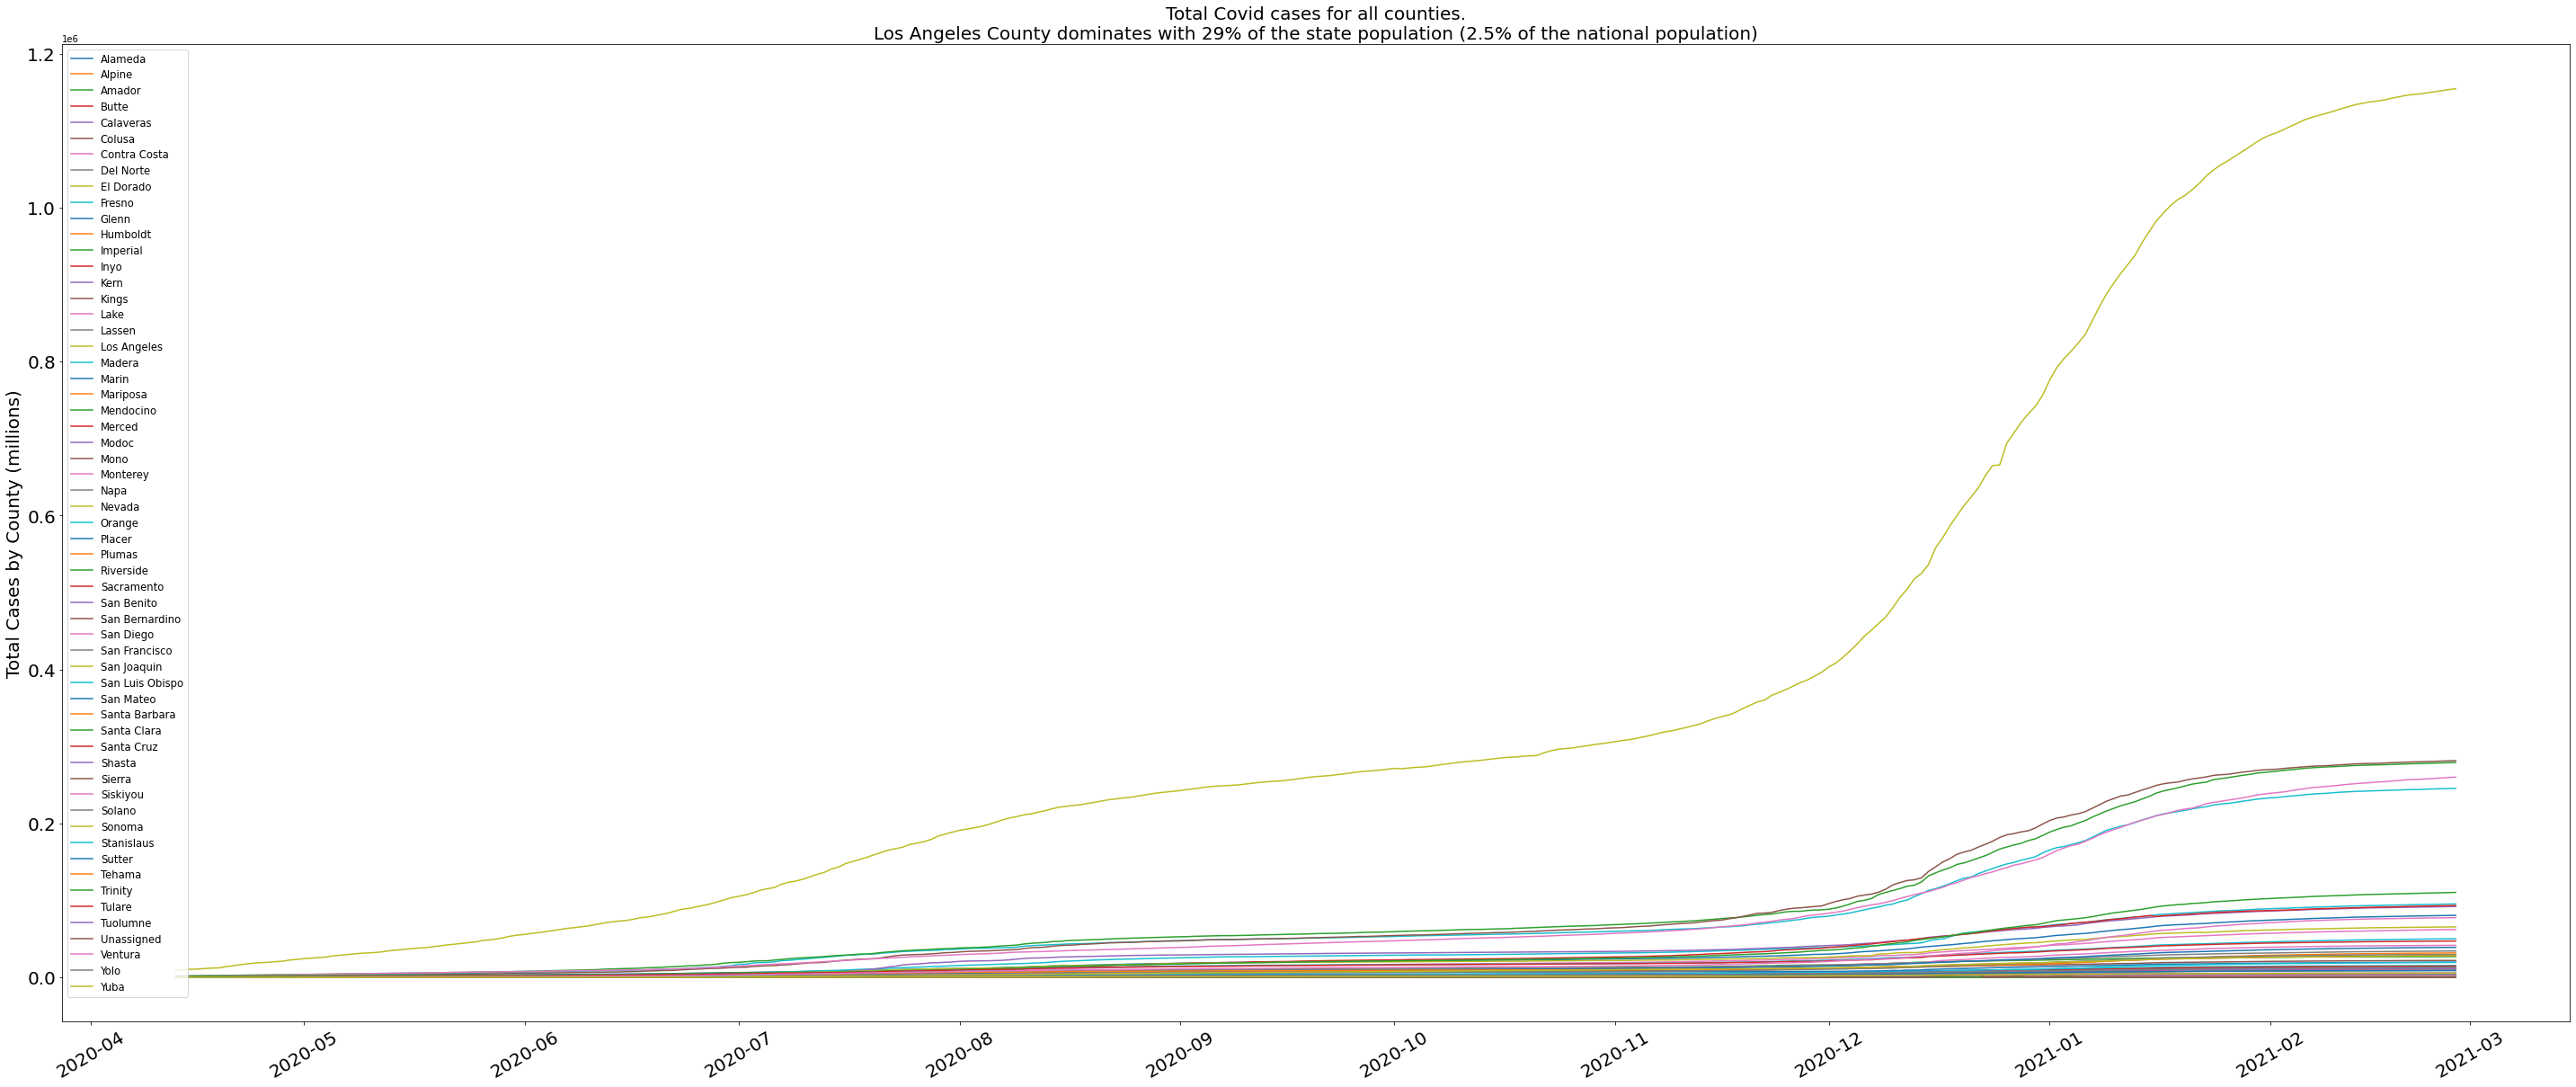

In [17]:
##########################################################################################
#//*** Quick illustration of why compareing counties in California is difficult
##########################################################################################

plt.rcParams['figure.figsize'] = [50,20]
plt.rcParams.update({'figure.max_open_warning': 0})

display_size = 20
fig,ax = plt.subplots()
for group in rd["Latino"].groupby("county"):
    loop_df = group[1]
    
   
    ax.plot(loop_df['date'],loop_df['cty_confirmed'], label=loop_df["county"].iloc[0])


        
plt.xticks(rotation=30,fontsize=display_size)
plt.yticks(fontsize=display_size)

handles,labels = deduplicate_legend(ax)
plt.legend(fontsize=display_size*.58,loc='upper left')
plt.title(f"Total Covid cases for all counties.\nLos Angeles County dominates with 29% of the state population (2.5% of the national population)",fontsize=display_size)
plt.ylabel("Total Cases by County (millions)",fontsize=display_size)
plt.show()


    
    
    

In [18]:
#//*** Rethink the Big Table (bt_df). 
#//*** Generate the New Big Table to help organize our thoughts.
#//*** Include county race and just the COVID numbers.
#//*** Generate the first population per 100k attributes for normalization

#//*** pop_100k - total California population / 100000
#//*** race_100k - total California racial population  / 100000
nbt_df = pd.DataFrame()

for col in ['date', 'race',"cases","deaths",'county','cty_newconfirm','cty_newdeath','state_confirmed','pop','pop_race']:
    nbt_df[col] = bt_df[col]

nbt_df['pop_100k'] = (nbt_df['pop'] / 100000).astype(int)
nbt_df = nbt_df[nbt_df['pop_100k'] > 0]
nbt_df['race_100k'] = (nbt_df['pop_race'] / 100000).astype(int)
nbt_df = nbt_df[nbt_df['race_100k'] > 0]
nbt_df['confirm_cty_100k'] = (nbt_df['cty_newconfirm'] / nbt_df['pop_100k']).astype(int)
#nbt_df['confirm_cty_7day_100k'] = nbt_df['confirm_cty_100k'].rolling(7).mean()
nbt_df['confirm_state_100k'] = (nbt_df['state_confirmed'] / nbt_df['pop_100k']).astype(int)

#//*** Some values are negative due to data collection errors / corrections
#//*** Set those values to 0
nbt_df[ nbt_df['confirm_cty_100k'] < 0]['confirm_cty_100k']  = 0
nbt_df[ nbt_df['confirm_state_100k'] < 0]['confirm_state_100k']  = 0

#nbt_df['death_cty_100k'] = (nbt_df['cty_newdeath'] / nbt_df['pop_100k']).astype(int)


#print(nbt_df['race'].unique())
#print(nbt_df[nbt_df['race'] == 'Latino'][nbt_df['county'] == 'Riverside'] [-100:])
print()

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
def update_dict_list(input_dict,input_key,input_data):
    
    if input_key not in input_dict.keys():
        input_dict[input_key] = [input_data]
    else:
        input_dict[input_key].append(input_data)
    
    return input_dict

def build_df_from_dict(input_dict):
    
    out_df = pd.DataFrame()
     
    for key,value in input_dict.items():
        out_df[key] = value
    
    return out_df 
    
#//*** 100k New Confirmed Statewide numbers for the Major Racial Categories.
#//*** State only provides totals, build a new dataframe and use pd.diff() to get the daily numbers
race_list_100k = nbt_df['race'].unique()
dates = list(bt_df['date'].unique())



t_dict = {}
for date in dates:
    #//*** Add the Date Field
    t_dict = update_dict_list(t_dict,'date',date)

    state_confirmed = nbt_df[nbt_df['date']==date]['state_confirmed'].iloc[0]
    t_dict = update_dict_list(t_dict,'all_races',state_confirmed)
    #t_dict = update_dict_list(t_dict,'state_c_100k',state_confirmed/pop_100k['total'])
    
    
    
    for race in race_list_100k:
        #//*** Get the Statewide Race cases for the date
        loop_cases = nbt_df[nbt_df['date']==date][nbt_df['race']==race]['cases'].iloc[0]
        t_dict = update_dict_list(t_dict,f"{race}",loop_cases)
        #t_dict = update_dict_list(t_dict,f"{race}_c_100k",loop_cases/pop_100k['total'])
        

state_race_df = build_df_from_dict(t_dict).diff(periods=1)
state_race_df = state_race_df.fillna(0)
state_race_df['date'] = pd.Series(t_dict['date'])

#//*** Convert new cases to statewide per 100k, skip the date column
for col in  state_race_df.columns[1:]:
    
    state_race_df[col] = state_race_df[col] / pop_100k['total']

print(state_race_df)




In [ ]:
#//*** Assigns a color from a palette list to a county. 
def assign_color(input_item, input_cd,input_palette):
    #//*** Check if item already exists, if so, return input_cd
    if input_item in input_cd.keys():
        return input_cd
    
    #//*** input_item needs a Color. Walk down the input_palette till one is not found
    for color in input_palette:
        if color not in input_cd.values():
            input_cd[input_item] = color
            return input_cd
    print("UH OH ran out of colors!!!")
    print(f"Item: {input_item}")
    print(input_cd)
    return input_cd

In [ ]:
for race in pop_state:
    print(race)

print(pop_state["Latino"] / pop_state['total'])

In [ ]:
print(state_race_df[ state_race_df['date'] == datetime.date(2021, 1, 10) ])
print(pop_state)

# Cases per 100,000 people.
To get all the counties onto a similar scale, it is helpful to look at the COVID in cases per 100,000 people. This metric allows large and small counties to compared on an equal footing. The State of California has based it's reopening plan based on a county's new cases per 100,000 people. The next graph looks at daily new COVID cases per 100,000 people across the entire State. At first glance the racial COVID numbers appear to be following the relative population sizes.

The big downside to this metric is that it does not capture populations less than 100k. There are counties with racial populations less than 100k that simply are not counted. I'm not terribly comfortable with large population segments being ignored, but this is the best method I have at the moment. Maybe reducing the scale to 10k might help.

In [ ]:
#//*** Plot Statewide New Case totals per 100k population
#//*** per 100k, gets everything on the same scale.
race_palette = ["#8651b8","#a84f72","#6b7744","#cb6d41","#73a6c0","#99ce65"]
race_palette = ["#F0817B","#E994C2","#A6BBF0","#4FDCE5","#74EEAB","#D8F06F"]


#//***Race Color Dict. Dictionary Key = County, Value = Color. Keeps the same colors for race across all graphs
rcd = {}

scale_size = 20
plt.rcParams['figure.figsize'] = [scale_size, scale_size] 
plt.rcParams.update({'figure.max_open_warning': 0})

fig,ax = plt.subplots()
#//*** Generate the expected values per race. Which is the Total number * race population percentage

for col in state_race_df.columns[1:]:
    #//*** Assign county color, so it is consistent across the graphs
    rcd = assign_color(col,rcd,race_palette)

    ax.plot(state_race_df['date'],state_race_df[col],color=rcd[col], label=col, linewidth=3)

    
plt.title("Statewide New COVID cases per 100k by race",fontsize=scale_size)
plt.legend(fontsize=scale_size,loc='upper left')
plt.ylabel('Daily New Cases per 100k',fontsize=scale_size)

plt.show()
    

# Checking Expectations
This next series compares the actual COVID cases based on race compared to the expected values in black. The expected value is the total statewide COVID cases multiplied by the racial population percentage. For Example: The Latino population represents 39% of California's population, therefore 39% of the COVID cases are expected to be Latino.

What's interesting about this series, is the Latino cases consistently exceeed the expected case values. This could indicate a racial disparity across the State in COVID cases. The other racial groups track well below expected values.

In [ ]:
#//*** Plot Statewide New Case totals per 100k population
#//*** per 100k, gets everything on the same scale.
race_palette = ["#8651b8","#a84f72","#6b7744","#cb6d41","#73a6c0","#99ce65"]
race_palette = ["#F0817B","#E994C2","#A6BBF0","#4FDCE5","#74EEAB","#D8F06F"]


#//***Race Color Dict. Dictionary Key = County, Value = Color. Keeps the same colors for race across all graphs
#rcd = {}

scale_size = 20
plt.rcParams['figure.figsize'] = [scale_size, scale_size] 
plt.rcParams.update({'figure.max_open_warning': 0})


#//*** Generate the expected values per race. Which is the Total number * race population percentage


for col in state_race_df.columns[2:]:
    print(col)
    #//*** Assign county color, so it is consistent across the graphs
    #rcd = assign_color(col,rcd,race_palette)
    fig,ax = plt.subplots()
    
    #ax.plot(state_race_df['date'],state_race_df['all_races'],color=rcd['all_races'], label='all_races', linewidth=3)

    ax.plot(state_race_df['date'],state_race_df["all_races"]* (pop_state[col] / pop_state['total']) ,color='black', label="expected", linewidth=5)

    ax.plot(state_race_df['date'],state_race_df[col],color=rcd[col], label=col, linewidth=3)
    
    
    plt.title("Statewide New COVID cases per 100k",fontsize=scale_size)
    plt.legend(fontsize=scale_size,loc='upper left')
    plt.ylabel('Daily New Cases per 100k',fontsize=scale_size)

    plt.show()


In [ ]:
#//*** Color Choices
color_palette = ["#c6eaff","#caa669","#14bae2","#f7cd89","#98a9e7","#e2ffb7","#cb9ec2","#77dcb5","#ffc5b7","#40bdba","#fff4b0","#74d0ff","#e4da8d","#7ceeff","#d0e195","#b7ab8c","#fcffdb","#83b88d","#ffe2c0","#abc37a"]
color_palette = ["#557788","#e12925","#44af0e","#7834c0","#726d00","#130c6d","#004e12","#f7007d","#017878","#950089","#00a3d7","#4b000e","#0063c2","#f07478","#013b75","#cf81b8","#212238","#af87e7","#320f49","#9c91db"]
county_color_palette = ["#b4a23b","#4457ca","#9ec535","#a651cb","#59ce59","#6a77f0","#52a325","#b93d9b","#36b25c","#e374d4","#c1c035","#7452af","#96ae3a","#a484e2","#89c466","#e54790","#57c888","#dd3d60","#5bd6c4","#dd4e2d","#45ccdf","#bd3738","#4cb998","#b13a6c","#368433","#588feb","#dcad3d","#4763af","#e49132","#4aa5d4","#c86321","#7695d3","#769233","#925898","#54701c","#c893d6","#3d7b44","#e084ac","#65a76b","#965179","#296437","#e57f5f","#31a8ad","#a44b2c","#368d71","#df7f81","#226a4d","#96465f","#b5b671","#68649c","#ad772e","#a34f52","#758348","#d8a06e","#505e25","#8e5e31","#8e8033","#695f1b"]
county_color_palette = ["#96465f","#dd3d60","#df7f81","#a34f52","#bd3738","#dd4e2d","#e57f5f","#a44b2c","#c86321","#8e5e31","#d8a06e","#e49132","#ad772e","#dcad3d","#b4a23b","#8e8033","#695f1b","#c1c035","#b5b671","#96ae3a","#505e25","#758348","#9ec535","#769233","#54701c","#52a325","#89c466","#368433","#59ce59","#3d7b44","#65a76b","#296437","#36b25c","#57c888","#226a4d","#368d71","#4cb998","#5bd6c4","#31a8ad","#45ccdf","#4aa5d4","#7695d3","#588feb","#4763af","#6a77f0","#4457ca","#68649c","#a484e2","#7452af","#a651cb","#c893d6","#925898","#e374d4","#b93d9b","#965179","#e084ac","#e54790","#b13a6c"]
county_color_palette = ["#226a4d","#31a8ad","#68649c","#758348","#505e25","#368d71","#4aa5d4","#965179","#7695d3","#45ccdf","#296437","#96465f","#8e5e31","#b5b671","#d8a06e","#a34f52","#5bd6c4","#695f1b","#4cb998","#df7f81","#3d7b44","#e084ac","#c893d6","#65a76b","#8e8033","#925898","#4763af","#54701c","#ad772e","#a44b2c","#e57f5f","#769233","#57c888","#b13a6c","#588feb","#a484e2","#b4a23b","#368433","#89c466","#7452af","#96ae3a","#dcad3d","#bd3738","#36b25c","#e374d4","#c86321","#b93d9b","#e49132","#dd3d60","#e54790","#c1c035","#4457ca","#6a77f0","#52a325","#9ec535","#dd4e2d","#a651cb","#59ce59"]

# County Case Rates
Setting aside racial disparities, how do the new COVID cases per 100k for each county compare. The next graph plots new COVID cases for each county and compares them with the statewide case rate per 100k. There are numerous counties with alarming case rates that deviate greatly from the Statewide norm. Imperial county is 85% Latino and consistently has a very high community COVID prevalence

In [ ]:
#//*** Color dict, holds the color palette associated with each county.
cd = {}

#//*** Scale Size: Sizing value for plotting and font size
ss = 20
plt.rcParams['figure.figsize'] = [ss, ss] 
plt.rcParams.update({'figure.max_open_warning': 0})

fig,ax = plt.subplots()

#//*** Plot Every county COVID Confirmed timeseries per 100k, compare with the statewide per 100k value
for loop_county in nbt_df['county'].sort_values().unique():
    loop_df = nbt_df[ nbt_df['county'] == loop_county ]
    loop_df = loop_df[loop_df['race'] == 'Latino']
           
    #//*** Assign county color, so it is consistent across the graphs
    cd = assign_color(loop_county,cd,county_color_palette)

    ax.plot(loop_df['date'], loop_df['confirm_cty_100k'], color=cd[loop_county],label=loop_county)

ax.plot(state_race_df['date'],state_race_df['all_races'],color=rcd['all_races'], label='all_races', linewidth=10)
ax.plot(state_race_df['date'],state_race_df['all_races'],color='white', linewidth=1)
plt.ylabel('Daily New Cases per 100k',fontsize=ss)    
plt.legend(loc='upper left', fontsize=ss*.5)
plt.show()


# Top Counties by Racial Percentage
This next series looks at a subset of counties based on the racial percentage of the population. These are the counties are selected since they have the highest racial portion of the county population. These are limited to counties that have racial populations greater than 100k.
Each county supplies the new COVID cases across the county without a racial breakdown. The next series looks at the compares the expected county racial covid cases with the statewide per 100,000 value. The expected county values are determined by taking the total county cases and multiplying by the racial population percentage.

It's interesting to note that counties with the highest percentage of a racial makeup, have expected per 100k values that exceed the statewide numbers. The counties with the highest Latino portion of the population have an alarming rates of COVID transmission.

In [ ]:
plt.rcParams['figure.figsize'] = [20, 20] 
plt.rcParams.update({'figure.max_open_warning': 0})

for loop_race in nbt_df['race'].unique():
    
    if loop_race == "Multiracial":
        continue
        
    #loop_county = rc[loop_race]['county_pop'][0]
    fig,ax = plt.subplots()
    county_count = 0
    
    for loop_county in rc[loop_race]['county_percent']:
       
        loop_df = nbt_df[nbt_df['county'] == loop_county ]
        loop_df = loop_df[ loop_df[ 'race'] == loop_race ]
                
        #//*** Skip counties that have less than 100k of a given population
        if loop_df['confirm_cty_100k'].isna().count() == 0:
            continue
        #//*** Assign county color, so it is consistent across the graphs
        cd = assign_color(loop_county,cd,county_color_palette)
        
        ax.plot(loop_df['date'], loop_df['confirm_cty_100k']*(loop_df['pop_race'] / loop_df['pop'] ), color=cd[loop_county],label=loop_county)
        county_count += 1
    ax.plot(state_race_df['date'],state_race_df[loop_race],color=rcd[loop_race], label=loop_race, linewidth=10)
    ax.plot(state_race_df['date'],state_race_df[loop_race],color="white", linewidth=1)
    ax.plot(state_race_df['date'],state_race_df['all_races'],color=rcd['all_races'], label='all_races', linewidth=10)
    ax.plot(state_race_df['date'],state_race_df['all_races'],color="white", linewidth=1)

    plt.title(f"Expected {loop_race} COVID Cases per 100k/population\nTop. {county_count} Counties by {loop_race} Population\n(Counties with > 100k {loop_race} population)")
    plt.ylabel('Daily New Cases per 100k',fontsize=scale_size)
    plt.legend()
    plt.show()
    
    


# More work to do
I'd like to focus on the counties who total population per 100,000 values exceed those of the State. If the list is long, then rank them by population, maybe the top 10.

The biggest next step would be building a linear regression that explores the relationship between the county covid numbers, state totals and the racial totals. Modeling the variance between these values may be able to capture the racial disparities at the county level

In [ ]:
#//*** trying to figure out when my county (Alameda) might hit 7 new cases per 100k or 112 total.
#//*** Add two weeks from that day and the county enters the red tier. Two weeks after that, my kids can return to the classroom.
#//*** I doubt it will happen before spring break :(

#//*** This exercise is how I figured out rolling 7 day averages
ala_df = rd["Latino"]
ala_df = ala_df[ala_df['county'] == 'Alameda']

temp_series = ala_df['cty_newconfirm'].rolling(7).mean()[-30:]

print(temp_series / 16)
print(ala_df[-30:])
print(ala_df[ala_df['cty_newconfirm'] < 150][-60:])

### Island of lost Toys
The code below I can't quite Marie Kondo. Some ideas I may want to revisit, but probably won't.

In [ ]:
"""
#//*** Let's run some correllations for funsies
pop_cols = ['population', 'Latino','White','Asian','Black','American Indian or Alaska Native', 'Hawaiian' ]
rf_cols = ['0rf_num', '1-2rf_num',  '3plrf_num']
rf_cols = ['0rf_rate', '1-2rf_rate',  '3plrf_rate']

for x in pop_cols:
    for y in rf_cols:
        print(f"{x} {y} - {pop_attrib_df[ [x,y] ].corr().iloc[0].iloc[1] }")
"""

In [ ]:
0#//*** Idea: Time Series Correlation. How does the Correlation shift with time. Starting at 30 days +, daily/weeklu/monthly cycle

In [ ]:
"""
#//*** Look at the correlations between race cases and county cases and statewide cases.
#//*** The idea is to capture the differences variation between the statewide race numbers, and the county total numbers
#//*** The relative difference variance may indicate the racial variable has variance that is not equal to the total state numbers 

def build_race_correlations(input_col1,input_col2,input_col3):
    output_dict = {}

    county_list = list(bt_df['county'].sort_values().unique())
    
    #//*** Loop Through race / county attributes looking for Race County Correlations.
    for loop_race in rc.keys():

        cor_pop = []
        cor_race = []
        race_percent = []

        for loop_county in county_list:

                loop_df = bt_df[bt_df['race']==loop_race]
                loop_df = loop_df[loop_df['county'] == loop_county]
                pop_cor = loop_df.corr()[input_col1][input_col3]
                race_cor = loop_df.corr()[input_col1][input_col2]
                race_percent.append(loop_df['percent_cty_pop'].iloc[0])

                cor_pop.append(pop_cor)
                cor_race.append(race_cor)
        out_df = pd.DataFrame()
        out_df['county'] = county_list
        out_df['pop_cor'] = cor_pop
        out_df['race_cor'] = cor_race
        out_df['dif_cor'] = out_df['race_cor'] - out_df['pop_cor']
        out_df['percent_dif_cor'] = out_df['race_cor'] / out_df['pop_cor']
        out_df['percent_cty_pop'] = race_percent
        #print(loop_race)
        #print(f"=======")
        #print(out_df.sort_values('dif_cor',ascending=False))
        #print(f"=======")

        output_dict[loop_race] = out_df
    return output_dict

#//*** Abstracting the correlationm columns.
col1 = 'confirmed'
col2 = 'cases'
col3 = 'state_confirmed'

#//*** Race County Confirmed Correlation: Stores Dataframes of Race/
#//*** Key = Race
#//*** Value County Correlation Dataframe
rccc = build_race_correlations('cty_confirmed','cases','state_confirmed')

#//*** Race County Death Correlation: Stores Dataframes of Race/
#//*** Key = Race
#//*** Value County Correlation Dataframe
#rccd = build_race_correlations('deaths','cases','state_confirmed')

                      
                    
"""

In [ ]:
"""
for race in rccc:
    print("============")
    print(race)
    print("============")
    print(rccc[race].sort_values('percent_dif_cor',ascending=False)[:10])
"""